# Module 2 Project: Northwind Database

### Assignment:  
Query the fictional Northwind Database and use statistical analysis to formulate and conduct Hypothesis Tests to answer 4 relevant business questions for the company.

Data will be extracted from the database using SQL Queries.  The data will be explored and used to form and answer the following business questions with hypothesis testing.

### 1.  How do discounts affect the number of products customers order?
### 2.  Does Northwind sell more alcoholic or non-alcoholic beverages?
### 3.  Is there a difference in sales volume between different offices?
### 4.  Do shipping costs vary bewteen the different carriers?

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

### Northwind Database Schema:
The below schema has been provided showing tables and relationships to access relevant data.

<img src='Northwind_ERD.png'>

In [2]:
#create an engine and connect to sqlite database using sqlalchemy
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()


In [3]:
#Getting the table names and viewing them 
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

2019-06-16 21:39:23,415 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-16 21:39:23,420 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,423 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-16 21:39:23,425 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,432 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-16 21:39:23,434 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [4]:
#previewing a table
inspector.get_columns('Category')

2019-06-16 21:39:23,462 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-06-16 21:39:23,464 INFO sqlalchemy.engine.base.Engine ()


[{'name': 'Id',
  'type': INTEGER(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'CategoryName',
  'type': VARCHAR(length=8000),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'Description',
  'type': VARCHAR(length=8000),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

Getting the columns of our tables prints out a list of dictionaries with more information than we need.  We will write a quick loop to extract the column names for each table for easy access.

In [5]:
table_columns = {}
for table in table_names:
    column_names = []
    for col in inspector.get_columns(table):
        column_names.append(col['name'])
    table_columns[table] = column_names

#previwing our new dictionary
table_columns.keys()
    

2019-06-16 21:39:23,496 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-06-16 21:39:23,498 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,505 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-06-16 21:39:23,507 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,512 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerDemographic")
2019-06-16 21:39:23,514 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,520 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-06-16 21:39:23,523 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,528 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("EmployeeTerritory")
2019-06-16 21:39:23,529 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,535 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-06-16 21:39:23,536 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 21:39:23,543 INFO sqlalchemy.engine.base.Engine PRAGMA

dict_keys(['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory'])

## Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

In [6]:
#inspecting OrderDetail table
table_columns['OrderDetail']

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

First we will extract necessary information from the Order Detail table into a pandas dataframe.

In [7]:
orders_discounts = pd.read_sql_query('''SELECT Quantity, Discount FROM OrderDetail''', engine)
orders_discounts.head(10)

2019-06-16 21:39:23,612 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount FROM OrderDetail
2019-06-16 21:39:23,615 INFO sqlalchemy.engine.base.Engine ()


,Quantity,Discount
0,12,0.00
1,10,0.00
2,5,0.00
3,9,0.00
4,40,0.00
5,10,0.00
6,35,0.15
7,15,0.15
8,6,0.05
9,15,0.05


In [8]:
orders_discounts.describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


We have 2155 orders with an average quantity of 23.8 and average discount around 5%.  Quantity ranges from 1 to 130 and Discount ranges from 0 - 25%.   

In [9]:
#Viewing unique discount levels and counts
orders_discounts.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

There are so few values for discounts of 1, 2, 3, 4 and 6% we can just combine those into the 5% discount group for the purposes of our experiment.

In [10]:
#Combining discounts greater than 0 and less than 0.10
orders_discounts['Discount'] = orders_discounts['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
orders_discounts['Discount'].value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

For the first part of our question we simply want to know if a discount significantly impacts the size of the order so we will create a binary Is_Discounted column.

In [11]:
orders_discounts['Is_Discounted'] = orders_discounts['Discount'].apply(lambda x: 1 if x > 0 else 0)

In [12]:
orders_discounts.head(10)

,Quantity,Discount,Is_Discounted
0,12,0.00,0
1,10,0.00,0
2,5,0.00,0
3,9,0.00,0
4,40,0.00,0
5,10,0.00,0
6,35,0.15,1
7,15,0.15,1
8,6,0.05,1
9,15,0.05,1


In [13]:
#Number of orders with and without Discounts
print(orders_discounts.groupby('Is_Discounted')['Quantity'].count())

Is_Discounted
0    1317
1     838
Name: Quantity, dtype: int64


In [14]:
#Mean quantity per order with and without Discounts
print(orders_discounts.groupby('Is_Discounted')['Quantity'].mean())

Is_Discounted
0    21.715262
1    27.109785
Name: Quantity, dtype: float64


More orders were placed without a discount, but the average quantity per order is higher with a discount applied.
Next we will split our data into the two groups, with and without to perform our Hypothesis test.

In [15]:
not_discounted = orders_discounts[orders_discounts['Is_Discounted'] == 0]
discounted = orders_discounts[orders_discounts['Is_Discounted'] == 1]
X = not_discounted.Quantity
Y = discounted.Quantity

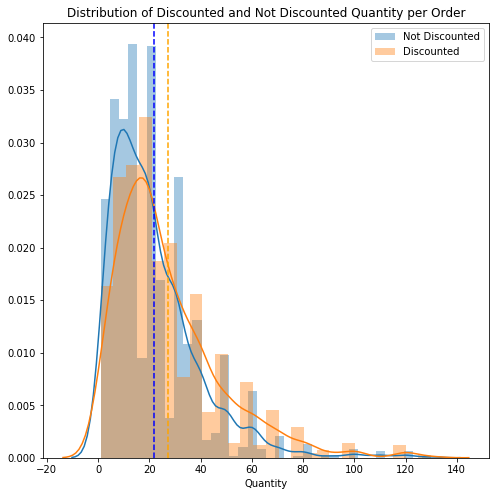

In [16]:
#Distribution for discounted vs non-discounted quantity. Eyeball test for normality.
plt.figure(figsize=(8,8))
sns.distplot(X, label = 'Not Discounted')
sns.distplot(Y, label = 'Discounted')
plt.axvline(X.mean(), linestyle = '--', color = 'blue')
plt.axvline(Y.mean(), linestyle = '--', color = 'orange')
plt.title("Distribution of Discounted and Not Discounted Quantity per Order")
plt.legend()
plt.show()

### Question 1, Part 1 - Hypothesis:   
$H\_0: \mu_1\= \mu_2\$  -- The average quantity of products per order is equal with or without discounts

$H\_A: \mu_1 >=  \mu_2\$ -- The average quantity of products per order increases with a discount.



In [17]:
#Levene Test for equal variance
stats.levene(X, Y)

LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)

The p-value of .0001 is less than than test statistic, so we reject the null hypothesis of equal variance.  For this reason we will use a one-sided Welch's t-test and an alpha of 0.025.

In [18]:
#Set alpha to 0.05/2 since running a 1-sided test
alpha = 0.025
#running Welch's t-test
t, p = stats.ttest_ind(X,Y, equal_var=False)
t, p

In [19]:
#Is p-value < alpha
p < alpha

True

In [20]:
def cohen_d(group1, group2):  
  
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

In [21]:
#calulating cohen's D
cohen_d(Y,X)

0.2862724481729283

### Result: Reject the Null

With a p-value less than alpha, we can reject the null hypothesis and conclude that **there is a statistically significant increase in the order of producs with a discount.**  Cohen's d statistic for our test is 0.28 which is a small to medium effect.

The second part of the question asks at what level of discount is there is significance.  

### Question 1, Part 2 - Hypothesis:

$H\_0: \mu_1 = \mu_2\ =\mu_3 ...  = \mu_k$  -- The average quantity of products per order is equal at all levels of discount

$H\_A: \mu_1\ \neq\  \mu_2\ \neq\ \mu_3\ ... \neq\ \mu_k$ -- The average quantity of products per changes depending on level of discount

In [22]:
discount_levels = discounted['Discount'].unique()
discount_levels

array([0.15, 0.05, 0.2 , 0.25, 0.1 ])

In [23]:
#Creating a small dataframe to see the average quantity per order by discount level
x = [0.05, 0.10, 0.15, 0.20, 0.25]
y = []
for i in x:
    y.append(discounted['Quantity'][discounted['Discount'] == i].mean())
    
df = pd.DataFrame(list(zip(x, y)), columns =['Discount', 'Avg Quantity']) 
df 



,Discount,Avg Quantity
0,0.05,26.922280
1,0.10,25.236994
2,0.15,28.382166
3,0.20,27.024845
4,0.25,28.240260


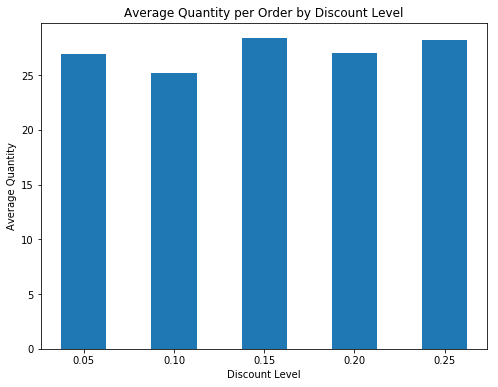

In [24]:
#Visualizing
plt.figure(figsize=(8,6))
plt.bar(x, y, align='center', width = .025)
plt.title('Average Quantity per Order by Discount Level')
plt.xlabel('Discount Level')
plt.ylabel('Average Quantity')
plt.show()

For this part of the question, whether the amount of discount applied is statistically significant, we can use an ANOVA Test to compare our 5 distinct discount levels. We will use an alpha value of 0.05 for this test since it is 2-sided.  We will then compare our p-value to alpha to evaluate.

In [25]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, discounted).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)
lm.summary()

                    sum_sq     df         F    PR(>F)
C(Discount)    1065.701253    4.0  0.616376  0.650947
Residual     360060.198508  833.0       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6164
Date:                Sun, 16 Jun 2019   Prob (F-statistic):              0.651
Time:                        21:39:25   Log-Likelihood:                -3729.5
No. Observations:                 838   AIC:                             7469.
Df Residuals:                     833   BIC:                             7493.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              26.9223      1.497     17.990      0.000      23.985      29.860
C(Discount)[T.0.1]     -1.6853      2.177     -0.774      0.439      -5.958       2.587
C(Discount)[T.0.15]     1.4599      2.234      0.653      0.514      -2.926       5.846
C(Discount)[T.0.2]      0.1026      2.219      0.046      0.963      -4.253       4.458
C(Discount)[T.0.25]     1.3180      2.246      0.587      0.558      -3.091       5.727
==============================================================================
Omnibus:                      265.156   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              753.997
Skew:                           1.593   Prob(JB):                    1.87e-164
Kurtosis:                       6.383   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
#Breaking data up into each level of discount.
five_percent = orders_discounts[orders_discounts['Discount'] == 0.05].Quantity
ten_percent = orders_discounts[orders_discounts['Discount'] == 0.10].Quantity
fifteen_percent = orders_discounts[orders_discounts['Discount'] == 0.15].Quantity
twenty_percent = orders_discounts[orders_discounts['Discount'] == 0.20].Quantity
twentyfive_percent = orders_discounts[orders_discounts['Discount'] == 0.25].Quantity
twentyfive_percent.head()
#len(five_percent), len(ten_percent), len(fifteen_percent), len(twenty_percent), len(twentyfive_percent)


34    16
36    15
37    21
43    60
45    60
Name: Quantity, dtype: int64

In [27]:
#Another way to run the Anova test, just for comparison.  Gives the same p-value.
print(stats.f_oneway(five_percent, ten_percent, fifteen_percent, twenty_percent, twentyfive_percent))


F_onewayResult(statistic=0.6163755029370473, pvalue=0.6509473814318465)


### Result: Fail to Reject the Null

With a p-value of 0.651, much greater than our alpha of 0.05, we cannot reject the null hypothesis that the quantity per order is equal for the 5 levels of discounts.   **There is not a statistically significant difference between levels of discount.**

### Recommendations/Further Study:


Our Hypotheis Testing in Question 1 shows that there is a statistically significant increase in average quantity per order when a discount is applied, but the magnitude of the discount does not have a significant effect.  Accordingly, Northwind should continue offering discounts where it is economically valuable but limit the degree of the discount. Customers order more when they think they are getting a good deal, regardless of how good the deal.  

Further work should be done to measure effects of discounts on revenue and not just number of products ordered.  Perhaps certain products are more prone to an increase in sales and therefore revenue than others.

## Question 2: Does Northwind sell more alcoholic or non-alcoholic beverages?

In [28]:
categories = pd.read_sql_query('''SELECT CategoryName, Description FROM Category''', engine)

2019-06-16 21:39:25,388 INFO sqlalchemy.engine.base.Engine SELECT CategoryName, Description FROM Category
2019-06-16 21:39:25,389 INFO sqlalchemy.engine.base.Engine ()


In [29]:
#Viewing Categories of Products sold by Northwind
categories

,CategoryName,Description
0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,Confections,"Desserts, candies, and sweet breads"
3,Dairy Products,Cheeses
4,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,Meat/Poultry,Prepared meats
6,Produce,Dried fruit and bean curd
7,Seafood,Seaweed and fish


In [30]:
#Making a dataframe of beverages sales by product
bev_product_sales = pd.read_sql_query('''SELECT c.CategoryName, p.ProductName, p.UnitPrice, od.Quantity, od.Discount FROM 
                                    Category c JOIN Product p ON c.ID = p.CategoryId
                                    JOIN OrderDetail od ON p.ID = od.ProductID WHERE
                                    CategoryName = "Beverages"
                                    ORDER BY p.ProductName''', engine)

2019-06-16 21:39:25,427 INFO sqlalchemy.engine.base.Engine SELECT c.CategoryName, p.ProductName, p.UnitPrice, od.Quantity, od.Discount FROM 
                                    Category c JOIN Product p ON c.ID = p.CategoryId
                                    JOIN OrderDetail od ON p.ID = od.ProductID WHERE
                                    CategoryName = "Beverages"
                                    ORDER BY p.ProductName
2019-06-16 21:39:25,428 INFO sqlalchemy.engine.base.Engine ()


In [31]:
#Viewing our new dataframe
bev_product_sales

,CategoryName,ProductName,UnitPrice,Quantity,Discount
0,Beverages,Chai,18.0,45,0.20
1,Beverages,Chai,18.0,18,0.00
2,Beverages,Chai,18.0,20,0.00
3,Beverages,Chai,18.0,15,0.15
4,Beverages,Chai,18.0,12,0.00
5,Beverages,Chai,18.0,15,0.15
6,Beverages,Chai,18.0,10,0.00
7,Beverages,Chai,18.0,24,0.00
8,Beverages,Chai,18.0,15,0.00
9,Beverages,Chai,18.0,40,0.20


In [32]:
#How many orders contained each Beverage product?
bev_product_sales['ProductName'].value_counts()

Guaraná Fantástica           51
Rhönbräu Klosterbier         46
Chang                        44
Lakkalikööri                 39
Outback Lager                39
Chai                         38
Steeleye Stout               36
Chartreuse verte             30
Ipoh Coffee                  28
Côte de Blaye                24
Sasquatch Ale                19
Laughing Lumberjack Lager    10
Name: ProductName, dtype: int64

In [33]:
#making lists of beverages by alcoholic or non-alcoholic
alc = ['Chang', 'Chartreuse verte', 'Côte de Blaye', 'Lakkalikööri', 'Laughing Lumberjack Lager', 'Outback Lager', 'Rhönbräu Klosterbier', 'Sasquatch Ale', 'Steeleye Stout']
non_alc = ['Chai', 'Guaraná Fantástica', 'Ipoh Coffee']
len(alc), len(non_alc)

(9, 3)

Northwind sells 9 types of alcoholic beverage and 3 types of non-alcoholic beverage.

In [34]:
#Split the data into alcoholic and non-alcoholic dataframes
alc_sales = bev_product_sales[bev_product_sales['ProductName'].isin(alc)]
non_alc_sales = bev_product_sales[bev_product_sales['ProductName'].isin(non_alc)]


### Beverage Sales by Revenue:

In [35]:
#Adding a column for revenue to alcoholic sales and previewing
alc_sales['Revenue'] = alc_sales['UnitPrice'] * alc_sales['Quantity'] * (1 - alc_sales['Discount'])
alc_sales.head()

,CategoryName,ProductName,UnitPrice,Quantity,Discount,Revenue
38,Beverages,Chang,19.0,20,0.0,380.0
39,Beverages,Chang,19.0,50,0.2,760.0
40,Beverages,Chang,19.0,35,0.0,665.0
41,Beverages,Chang,19.0,40,0.0,760.0
42,Beverages,Chang,19.0,25,0.2,380.0


In [36]:
#Calculating revenue for sales of alcoholic beverages
alc_rev = alc_sales['Revenue'].sum()
alc_rev

245443.8

In [37]:
#Adding a column for revenue to non_alcoholic sales and previewing
non_alc_sales['Revenue'] = non_alc_sales['UnitPrice'] * non_alc_sales['Quantity'] * (1 - non_alc_sales['Discount'])
non_alc_sales.head()

,CategoryName,ProductName,UnitPrice,Quantity,Discount,Revenue
0,Beverages,Chai,18.0,45,0.20,648.0
1,Beverages,Chai,18.0,18,0.00,324.0
2,Beverages,Chai,18.0,20,0.00,360.0
3,Beverages,Chai,18.0,15,0.15,229.5
4,Beverages,Chai,18.0,12,0.00,216.0


In [38]:
#Calculating revenue for sales of non_alcoholic beverages
non_alc_rev = non_alc_sales['Revenue'].sum()
non_alc_rev

43250.85

In [39]:
#How much more revenue does Northwind make from alcoholic vs non-alcoholic beverages
alc_rev / non_alc_rev

5.674889626446648

On a revenue basis, there is no comparison between alcoholic and non-alcoholic beverages, as Northwind makes over 5.5x as much revenue on alcoholic beverages.  But what if we look at quantity per order?

### Beverage Sales by Quantity per Order:

In [40]:
print(f'There are {alc_sales.shape[0]} orders of alcoholic beverages.')
print(f'There are {non_alc_sales.shape[0]} orders of non-alcoholic beverages.')

There are 287 orders of alcoholic beverages.
There are 117 orders of non-alcoholic beverages.


In [41]:
#Calculating the mean quantity per order for alcoholic and non-alcoholic beverages
a = alc_sales['Quantity'].mean()
na = non_alc_sales['Quantity'].mean()
a,na

(24.386759581881535, 21.64957264957265)

In [42]:
print(f'The mean quantity of alcoholic beverages orders is {round(a,2)}')
print(f'The mean quantity of non-alcoholic beverages orders is {round(na,2)}')

The mean quantity of alcoholic beverages orders is 24.39
The mean quantity of non-alcoholic beverages orders is 21.65


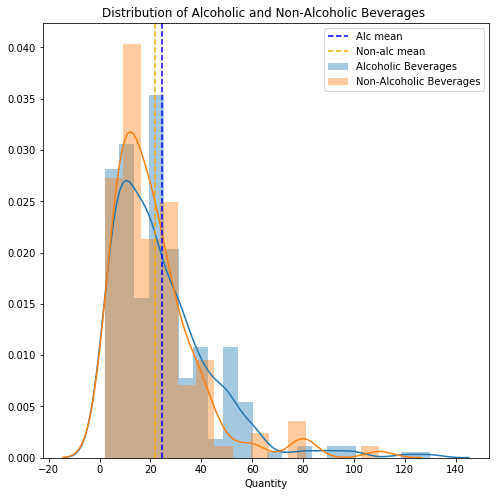

In [43]:
#Distribution for discounted vs non-discounted quantity. Eyeball test for normality.
plt.figure(figsize=(8,8))
sns.distplot(alc_sales['Quantity'], label = 'Alcoholic Beverages')
sns.distplot(non_alc_sales['Quantity'], label = 'Non-Alcoholic Beverages')
plt.axvline(a, linestyle = '--', label = 'Alc mean', color = 'b')
plt.axvline(na, linestyle = '--', label = 'Non-alc mean', color = 'orange')
plt.title("Distribution of Alcoholic and Non-Alcoholic Beverages ")
plt.legend()
plt.show()

### Question 2 - Hypothesis:
$H\_0: \mu_1\= \mu_2\$  -- The average quantity of alcoholic and non-alcoholic drinks per order are equal.

$H\_A: \mu_1\ \neq\  \mu_2\$ -- The average quantity of alcoholic and non-alcoholic drinks per order are not equal.


The data is not normally distributed, it is right-skewed.  However, the 2-sample t-test should be robust to the assumption of normality.  We will run a Levene Test to see if they have the same variance with alpha set to 0.05

In [44]:
#Levene test for equal variance
stats.levene(alc_sales['Quantity'], non_alc_sales['Quantity'])

LeveneResult(statistic=1.7603441608680084, pvalue=0.1853347458308032)

The p-value is greater than alpha so we can accept the null hypothesis of equal variance and use an independent 2-sample t-test with alpha value of 0.05

In [45]:
#Run independent 2-sample t-test with alpha of 0.05
alpha=0.05
t, p = stats.ttest_ind(alc_sales['Quantity'], non_alc_sales['Quantity'], equal_var=True)
t, p

(1.299274131444229, 0.19459451336460287)

In [46]:
p > alpha

True

### Result:  Fail to reject the Null

With a p-value greater than our alpha of 0.05, we fail to reject the null.  **On a per order basis, there is no significant difference between quantities of alcoholic and non-alcoholic beverages ordered.**  


### Recommendation:

We saw above that Northwind makes a much greater amount of revenue selling alcoholic beverages vs non-alcoholic beverages.  Close to 6x as much.  It is no surprise when they sell 9 types of alcoholic beverage and only 3 non-alcoholic.  However, our hypothesis test on the mean quantity per order of the two categories showed a lack of statistically significant difference.  Customers order nearly as high a quantity of non-alcohlic beverages.  Northwind would be wise to expand their non-alcoholic product line, perhaps offering more varieties of coffee and tea, or entering into the flavored water or energy drink market.

## Question 3:  Is there a difference in revenues between the US and UK offices?

In [47]:
#Checking columns in the Employee table
table_columns['Employee']

['Id',
 'LastName',
 'FirstName',
 'Title',
 'TitleOfCourtesy',
 'BirthDate',
 'HireDate',
 'Address',
 'City',
 'Region',
 'PostalCode',
 'Country',
 'HomePhone',
 'Extension',
 'Photo',
 'Notes',
 'ReportsTo',
 'PhotoPath']

In [48]:
#Let's check who works at Northwind
employees = pd.read_sql_query('''SELECT Id, LastName, FirstName, Title, Region, City FROM Employee''', engine)
employees

2019-06-16 21:39:26,498 INFO sqlalchemy.engine.base.Engine SELECT Id, LastName, FirstName, Title, Region, City FROM Employee
2019-06-16 21:39:26,500 INFO sqlalchemy.engine.base.Engine ()


,Id,LastName,FirstName,Title,Region,City
0,1,Davolio,Nancy,Sales Representative,North America,Seattle
1,2,Fuller,Andrew,"Vice President, Sales",North America,Tacoma
2,3,Leverling,Janet,Sales Representative,North America,Kirkland
3,4,Peacock,Margaret,Sales Representative,North America,Redmond
4,5,Buchanan,Steven,Sales Manager,British Isles,London
5,6,Suyama,Michael,Sales Representative,British Isles,London
6,7,King,Robert,Sales Representative,British Isles,London
7,8,Callahan,Laura,Inside Sales Coordinator,North America,Seattle
8,9,Dodsworth,Anne,Sales Representative,British Isles,London


Northwind has 9 employees, all in sales, across two regions: North America and British Isles.  We can surmise that Northwind has offices in Seattle and London (although Mr. Fuller, our VP of Sales in North America has a pretty decent commute from Tacoma!).

We will make a dataframe with employees and sales revenue and split it up by US vs UK to test if there is a difference in sales between the two regions.

In [49]:
employee_sales = pd.read_sql_query('''SELECT o.EmployeeId, e.City Office,
                                    od.OrderId, SUM(od.UnitPrice * od.Quantity * (1-od.Discount)) Revenue
                                    FROM EMPLOYEE e JOIN [ORDER] o ON E.Id = o.EmployeeId
                                    JOIN OrderDetail od ON o.Id = od.OrderId
                                    GROUP BY od.OrderId 
                                    ORDER BY e.Id''', engine)

2019-06-16 21:39:26,540 INFO sqlalchemy.engine.base.Engine SELECT o.EmployeeId, e.City Office,
                                    od.OrderId, SUM(od.UnitPrice * od.Quantity * (1-od.Discount)) Revenue
                                    FROM EMPLOYEE e JOIN [ORDER] o ON E.Id = o.EmployeeId
                                    JOIN OrderDetail od ON o.Id = od.OrderId
                                    GROUP BY od.OrderId 
                                    ORDER BY e.Id
2019-06-16 21:39:26,542 INFO sqlalchemy.engine.base.Engine ()


In [50]:
employee_sales.head()

,EmployeeId,Office,OrderId,Revenue
0,1,Seattle,10258,1614.88
1,1,Seattle,10270,1376.00
2,1,Seattle,10275,291.84
3,1,Seattle,10285,1743.36
4,1,Seattle,10292,1296.00


In [51]:
len(employee_sales)

830

In [52]:
#Splitting the dataset into US and UK sales
UK_sales = employee_sales[employee_sales['Office'] == 'London']
US_sales = employee_sales[employee_sales['Office'] != 'London']

In [53]:
UK_sales.describe()

,EmployeeId,OrderId,Revenue
count,224.000000,224.000000,224.000000
mean,6.709821,10665.075893,1538.311221
std,1.319292,236.639797,1892.265365
min,5.000000,10248.000000,12.500000
25%,6.000000,10482.250000,454.066250
50%,7.000000,10666.500000,868.650000
75%,7.000000,10869.250000,1896.087500
max,9.000000,11074.000000,12615.050000


In [54]:
US_sales.describe()

,EmployeeId,OrderId,Revenue
count,606.000000,606.000000,606.000000
mean,3.551155,10661.547855,1520.150703
std,2.285388,241.069141,1829.031323
min,1.000000,10250.000000,18.400000
25%,2.000000,10449.250000,456.750000
50%,3.000000,10661.000000,1013.872500
75%,4.000000,10871.000000,1847.660000
max,8.000000,11077.000000,16387.500000


In [55]:
london_rev = UK_sales.Revenue
seattle_rev = US_sales.Revenue

In [56]:
print(f'The total revenue for the London office was ${(round(london_rev.sum(),2))}.')
print(f'The total revenue for the Seattle offce was ${round(seattle_rev.sum(),2)}.')

The total revenue for the London office was $344581.71.
The total revenue for the Seattle offce was $921211.33.


Northwind makes a much greater total revenue out of the US/Seattle office, but we want to investigate if there is a difference in the average revenue per sale between the two centers.

In [57]:
#Calculating the mean revenue per order for the two centers.
london_mean = london_rev.mean()
seattle_mean = seattle_rev.mean()
print(f'The mean revenue per order in London was {london_mean}.')
print(f'The mean revenue per order in Seattle was {seattle_mean}.')

The mean revenue per order in London was 1538.3112209821425.
The mean revenue per order in Seattle was 1520.1507029702982.


Despite the large overall difference in revenue, the means per order are farily similar and London's is a bit higher.

### Question 3 - Hypothesis:
$H\_0: \mu_1\= \mu_2\$  -- The mean revenue per order is the same in the London office and Seattle office.

$H\_A: \mu_1\ \neq  \mu_2\$ -- The mean revenue per order is not equal between the two centers.



In [58]:
print(f'There are {len(UK_sales)} orders from the London office.')
print(f'There are {len(US_sales)} orders from the Seattle office.')

There are 224 orders from the London office.
There are 606 orders from the Seattle office.


These are big enough sample sizes to test, so we will look at their distributions as an eyeball test for normality.

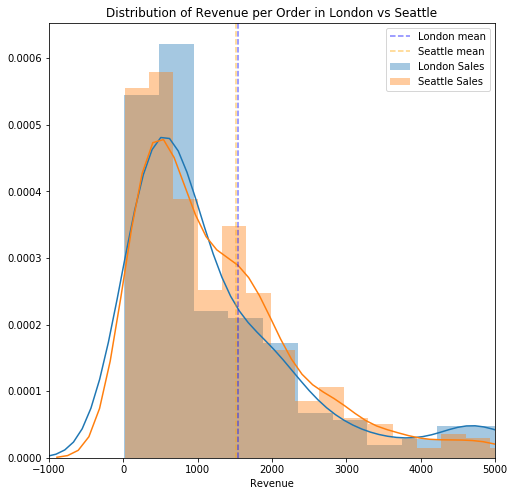

In [59]:
#Plotting distributions of revenue per order of London vs. Seattle
plt.figure(figsize=(8,8))
sns.distplot(london_rev, label = 'London Sales')
sns.distplot(seattle_rev, label = 'Seattle Sales')
plt.axvline(london_mean, linestyle = '--', label = 'London mean', color = 'b', alpha = 0.5)
plt.axvline(seattle_mean, linestyle = '--', label = 'Seattle mean', color = 'orange', alpha = 0.5)
plt.title("Distribution of Revenue per Order in London vs Seattle")
plt.xlim(-1000, 5000) #zooming in a bit to better view the distribution
plt.legend()
plt.show()


As we can see, these data samples are not exactly normally distributed.  Each exhibit positive skew.  However, with the sufficient sample sizes of 224 and 606 we can proceed with a one-sided two-sample t-test, using an alpha of 0.05.  

In [60]:
#Levene test for equal variance
stats.levene(london_rev, seattle_rev)

LeveneResult(statistic=0.2298103387475599, pvalue=0.6317910824369707)

The Levene test shows a high p-value of 0.63 meaning we fail to reject the null hypothesis of equal variance and can proceed to run the student's t-test with equal variance.

In [61]:
#Run independent two-sample t-test
stats.ttest_ind(london_rev, seattle_rev, equal_var=True)

Ttest_indResult(statistic=0.1257920376990175, pvalue=0.8999270811672762)

### Result: Fail to Reject the Null Hypothesis.
   

With a p-value of 0.90 much greater than our alpha of 0.05, we fail to reject the null and find **no significant difference between revenue per order in the London and Seattle offices.**

### Recommendations/Further Work:

Our test of the revenue per order between the 2 centers showed that there is no significant difference between them.  However, we also saw that despite only having 1 extra employee (5 vs 4) the Seattle office makes over 2.5x the revenue of the London office.  By order size, the London reps are keeping up with their US counterparts but the Seattle office filled 606 orders compared to only 224 in London.  Further study should be done to determine what makes up for that difference, whether it is market/geography based (ie. the Seattle team covers a much larger territory) or cultural (some other factors prohibiting the salespeople in London from making as many sales).

## Question 4:  Do Freight costs per order differ between Northwind's various Shipping Companies?

In [62]:
#Taking another glance at table names 
table_names

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [63]:
#Checking columns in the Shipper table
table_columns['Shipper']

['Id', 'CompanyName', 'Phone']

In [64]:
#Checking columns in the Order table
table_columns['Order']

['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

For this question we will look at freight costs and shipping company for each order, by joining the Order and Shipping tables.

In [65]:
#Extract data into a pandas dataframe
shipping = pd.read_sql_query('''SELECT o.Id OrderId, o.Freight, s.Id ShipperId, 
                                s.CompanyName FROM [Order] o JOIN Shipper s ON 
                                o.ShipVia = s.Id ORDER BY s.Id''', engine)

2019-06-16 21:39:27,732 INFO sqlalchemy.engine.base.Engine SELECT o.Id OrderId, o.Freight, s.Id ShipperId, 
                                s.CompanyName FROM [Order] o JOIN Shipper s ON 
                                o.ShipVia = s.Id ORDER BY s.Id
2019-06-16 21:39:27,733 INFO sqlalchemy.engine.base.Engine ()


In [66]:
shipping.head()

,OrderId,Freight,ShipperId,CompanyName
0,10249,11.61,1,Speedy Express
1,10251,41.34,1,Speedy Express
2,10258,140.51,1,Speedy Express
3,10260,55.09,1,Speedy Express
4,10265,55.28,1,Speedy Express


In [67]:
#How many shipping companies does Northwind use and how many orders has each filled?
shipping.CompanyName.value_counts()

United Package      326
Federal Shipping    255
Speedy Express      249
Name: CompanyName, dtype: int64

In [68]:
shipping.describe()

,OrderId,Freight,ShipperId
count,830.000000,830.000000,830.000000
mean,10662.500000,78.244205,2.007229
std,239.744656,116.779294,0.779685
min,10248.000000,0.020000,1.000000
25%,10455.250000,13.380000,1.000000
50%,10662.500000,41.360000,2.000000
75%,10869.750000,91.430000,3.000000
max,11077.000000,1007.640000,3.000000


After some cursory data exploration we see that for the 830 orders in our dataset, Northwind has used 3 different shipping companyies: United Package for 326 orders, Federal Shipping for 255 orders and Speedy Express for 249 orders.

The mean freight cost per order is $78.24.  We will examine if there is a difference in shipping costs between the 3 companies.

In [69]:
#Splitting the dataset into groups of the 3 shipping companies
united = shipping[shipping['CompanyName'] == 'United Package']
federal = shipping[shipping['CompanyName'] == 'Federal Shipping']
speedy = shipping[shipping['CompanyName'] == 'Speedy Express']

In [70]:
#Previewing our separated data
display(united.head())
display(federal.head()) 
display(speedy.head())

,OrderId,Freight,ShipperId,CompanyName
249,10250,65.83,2,United Package
250,10252,51.30,2,United Package
251,10253,58.17,2,United Package
252,10254,22.98,2,United Package
253,10256,13.97,2,United Package


,OrderId,Freight,ShipperId,CompanyName
575,10248,32.38,3,Federal Shipping
576,10255,148.33,3,Federal Shipping
577,10257,81.91,3,Federal Shipping
578,10259,3.25,3,Federal Shipping
579,10262,48.29,3,Federal Shipping


,OrderId,Freight,ShipperId,CompanyName
0,10249,11.61,1,Speedy Express
1,10251,41.34,1,Speedy Express
2,10258,140.51,1,Speedy Express
3,10260,55.09,1,Speedy Express
4,10265,55.28,1,Speedy Express


In [71]:
#Calculating mean shipping costs for reach company
united_mean = round(united.Freight.mean(),2)
federal_mean = round(federal.Freight.mean(),2)
speedy_mean = round(speedy.Freight.mean(),2)
print(f'The mean freight cost for United Package is ${united_mean}.')
print(f'The mean freight cost for Federal Shipping is ${federal_mean}.')
print(f'The mean freight cost for Speedy Express is ${speedy_mean}.')

The mean freight cost for United Package is $86.64.
The mean freight cost for Federal Shipping is $80.44.
The mean freight cost for Speedy Express is $65.0.


### Question 4 - Hypothesis:
$H\_0: \mu_1\ = \mu_2\ = \mu_3$  -- There is no difference in mean freight cost between the 3 shipping companies.

$H\_A: \mu_1\ \neq  \mu_2\ \neq\ \mu3$ -- The mean freight cost is not equal between the 3 shipping companies.


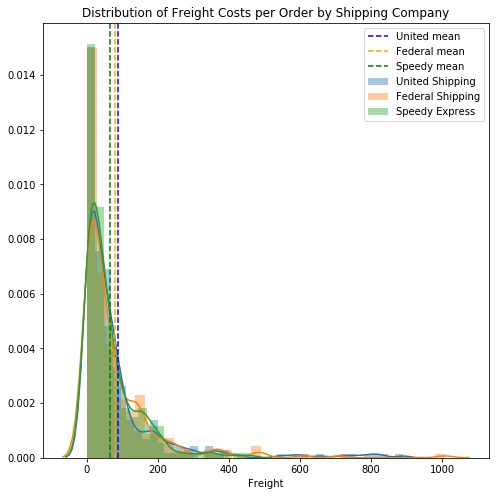

In [72]:
#Displaying the distribution of Freight costs for the 3 shipping companies
plt.figure(figsize=(8,8))
sns.distplot(united.Freight, label = 'United Shipping')
sns.distplot(federal.Freight, label = 'Federal Shipping')
sns.distplot(speedy.Freight, label = 'Speedy Express')
plt.axvline(united_mean, linestyle = '--', label = 'United mean', color = 'b')
plt.axvline(federal_mean, linestyle = '--', label = 'Federal mean', color = 'orange')
plt.axvline(speedy_mean, linestyle = '--', label = 'Speedy mean', color = 'g')
plt.title("Distribution of Freight Costs per Order by Shipping Company")
#plt.xlim(-50, 300) Decided not to use this because we log transform the data below
plt.legend()
plt.show()

The data is very positively-skewed so we will take a different look of it, after log transforming the Freight costs.

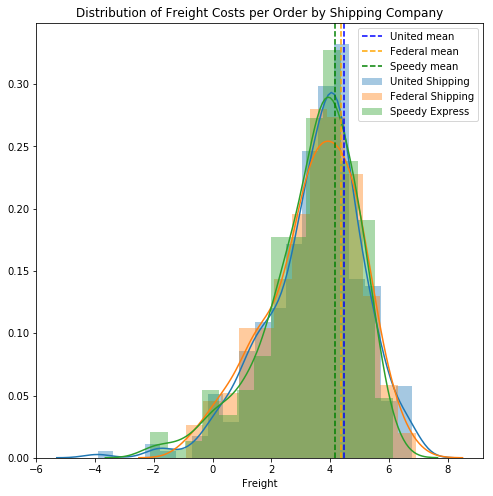

In [73]:
plt.figure(figsize=(8,8))
sns.distplot(np.log(united.Freight), label = 'United Shipping')
sns.distplot(np.log(federal.Freight), label = 'Federal Shipping')
sns.distplot(np.log(speedy.Freight), label = 'Speedy Express')
plt.axvline(np.log(united_mean), linestyle = '--', label = 'United mean', color = 'b')
plt.axvline(np.log(federal_mean), linestyle = '--', label = 'Federal mean', color = 'orange')
plt.axvline(np.log(speedy_mean), linestyle = '--', label = 'Speedy mean', color = 'g')
plt.title("Distribution of Freight Costs per Order by Shipping Company")
plt.legend()
plt.show()

In [74]:
#Levene Test for equal variance with alpha 0.05
stats.levene(np.log(united.Freight), np.log(federal.Freight), np.log(speedy.Freight))

LeveneResult(statistic=0.315073827875784, pvalue=0.7298225542862442)

In [75]:
log_shipping = shipping.copy()
log_shipping['Freight'] = np.log(shipping['Freight'])
log_shipping.head()

,OrderId,Freight,ShipperId,CompanyName
0,10249,2.451867,1,Speedy Express
1,10251,3.721831,1,Speedy Express
2,10258,4.945279,1,Speedy Express
3,10260,4.008968,1,Speedy Express
4,10265,4.012411,1,Speedy Express


In [76]:
#Anova test with alpha 0.05
formula = 'Freight ~ C(CompanyName)'
lm = ols(formula, log_shipping).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)
lm.summary()

                     sum_sq     df         F    PR(>F)
C(CompanyName)     1.816553    2.0  0.361166  0.696973
Residual        2079.778316  827.0       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Freight   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3612
Date:                Sun, 16 Jun 2019   Prob (F-statistic):              0.697
Time:                        21:39:29   Log-Likelihood:                -1558.9
No. Observations:                 830   AIC:                             3124.
Df Residuals:                     827   BIC:                             3138.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            3.4582      0.099     34.823      0.000       3.263       3.653
C(CompanyName)[T.Speedy Express]    -0.0795      0.141     -0.563      0.574      -0.357       0.198
C(CompanyName)[T.United Package]     0.0325      0.133      0.245      0.806      -0.228       0.293
==============================================================================
Omnibus:                       81.455   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.386
Skew:                          -0.779   Prob(JB):                     4.80e-24
Kurtosis:                       3.822   Cond. No.                         3.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
#Tukey Multicomparison Test
mc = sm.stats.multicomp.MultiComparison(log_shipping['Freight'],log_shipping['CompanyName'])
result = mc.tukeyhsd()
result.summary()

group1,group2,meandiff,lower,upper,reject
Federal Shipping,Speedy Express,-0.0795,-0.4112,0.2523,False
Federal Shipping,United Package,0.0325,-0.2788,0.3438,False
Speedy Express,United Package,0.112,-0.2014,0.4254,False


### Result: Fail to Reject the Null Hypothesis

The ANOVA p-value is 0.697 which is greater than our alpha of 0.05 so we fail to reject the null and find **no significant difference between the freight costs of the 3 shipping companies employed by Northwind.**  

This is confirmed with a Tukey Multicomparison Test which failed to reject the null for all 3 individual comparisons between the companies.

### Recommendation:

Given that there is no significant difference in the frieght costs of the 3 companies, there is no reason to recommend using only 1 or 2 of the companies.  Further study could perhaps show which region each company operates (best) in.  The shipping department should also continue to use the competitive nature of the shipping business to negotiate for better rates and take advantage of any bulk discounts or promotions.

## Conclusions:
 - Dicsounts increase sales on a per order basis but the level of discount is not significant.
 - Northwind makes much greater revenue selling alcoholic beverages than non-alcoholic beverages but on a per order basis there is not
 - The Seattle office makes 2.5x the revenue of the London office, but on a per sale basis they do not vary significantly
 - No significant difference in freight costs between the 3 shipping companies.
 
### Recommendations:
 - Offer more discounts on products but keep them low.
 - Expand the non-alcoholic beverage product line.
 - Explore why the team in London is not making as many sales, use the Seattle office as a model.
 - Continue to negotiate rates with the 3 companies to make shipping as cost-efficient as possible.
 
### Further Work:
 - Are discounts more effective on certain products or regions?
 - Market research into beverage sales and trends.  What new non-alcoholic products are likely to be successful?
 - Study sales by region and office - assess whether sales teams should be assembled in other cities.
 - Effectiveness of shipping companies by region or product.  Is there any statistical difference in shipping speeds?